<a href="https://colab.research.google.com/github/oneicar/ProyectoClase15/blob/main/Taller_1_Ejercicio_4_Oneicar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 665 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings  # Para ignorar mensajes de advertencia

warnings.filterwarnings("ignore")

In [3]:
import yfinance as yf

In [4]:
tickers = ["DIS"]
disney = yf.download(tickers, period="max")
print(disney.tail())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-08-23  115.980003  116.370003  114.620003  114.860001  114.860001   
2022-08-24  114.669998  117.160004  114.099998  116.410004  116.410004   
2022-08-25  117.019997  117.769997  116.110001  117.459999  117.459999   
2022-08-26  117.470001  118.370003  113.889999  114.070000  114.070000   
2022-08-29  112.540001  114.467300  112.410004  113.529999  113.529999   

             Volume  
Date                 
2022-08-23  7180700  
2022-08-24  7840500  
2022-08-25  6920900  
2022-08-26  7793900  
2022-08-29  6844290  


In [6]:
df = disney["Adj Close"].dropna(how="all")
df.tail()

Date
2022-08-23    114.860001
2022-08-24    116.410004
2022-08-25    117.459999
2022-08-26    114.070000
2022-08-29    113.529999
Name: Adj Close, dtype: float64

In [7]:
df.shape

(15270,)

In [8]:
df = np.array(df[:, np.newaxis])
df.shape

(15270, 1)

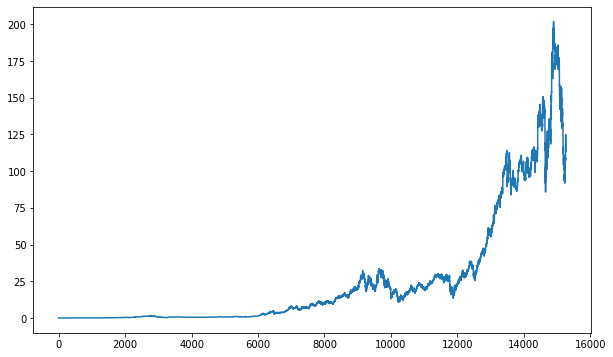

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(df)

# **Conjunto de train y test:**

In [10]:
time_test = 0.30

In [11]:
int(len(df) * (1 - time_test))

10689

In [13]:
train = df[: int(len(df) * (1 - time_test))]
test = df[int(len(df) * (1 - time_test)) :]

In [14]:
train.shape

(10689, 1)

In [15]:
test.shape

(4581, 1)

Por otro lado, también se pueden dividir los datos en función de una cantidad de períodos en lugar de un porcentaje, por ejemplo, para tener los últimos 200 períodos para el conjunto de test, como se muestra a continuación: 

time_test = 200

train = df[:len(df)-time_test]

test = df[len(df)-time_test:]

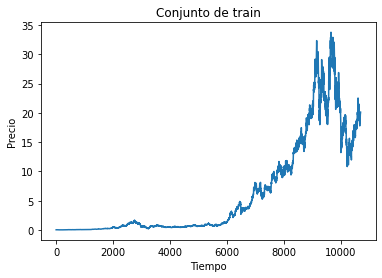

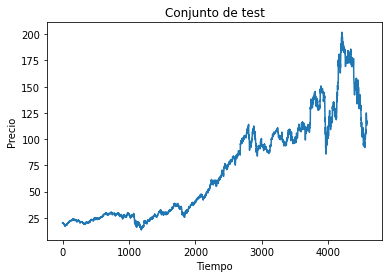

In [16]:
plt.plot(train)
plt.xlabel("Tiempo")
plt.ylabel("Precio")
plt.title("Conjunto de train")
plt.show()

plt.plot(test)
plt.xlabel("Tiempo")
plt.ylabel("Precio")
plt.title("Conjunto de test")
plt.show()

# **Estandarización de las variables:**

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
sc = StandardScaler()
sc.fit(train)
train = sc.transform(train)
test = sc.transform(test)

In [19]:
train[0:5]

array([[-0.73938227],
       [-0.73928733],
       [-0.73928733],
       [-0.73926357],
       [-0.73928733]])

In [20]:
test[0:5]

array([[1.68567284],
       [1.68274851],
       [1.65642846],
       [1.72368948],
       [1.70809333]])

**Función para conformar el dataset para datos secuenciales:**

[time_step, Features]

In [21]:
def split_sequence(sequence, time_step):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + time_step
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

Se usaran 20 datos secuenciales para predecir el siguiente valor

In [22]:
time_step = 20

X_train, y_train = split_sequence(train, time_step)
X_test, y_test = split_sequence(test, time_step)

# **Arquitectura de la red:**

Entrenamiento con el conjunto de train y evaluación con el conjunto de test:

In [23]:
from keras.models import Sequential
from keras.layers import Dense

In [25]:
model = Sequential()
model.add(Dense(10, activation="relu", input_shape=(time_step,)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=50,
    verbose=0,
)

# **Evaluación del desempeño:**

In [ ]:
model.evaluate(X_test, y_test)

52/52 [==============================] - 0s 2ms/step - loss: 0.0317


0.031668681651353836

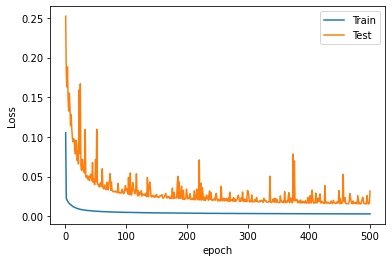

In [ ]:
plt.plot(range(1, len(history.epoch) + 1), history.history["loss"], label="Train")
plt.plot(range(1, len(history.epoch) + 1), history.history["val_loss"], label="Test")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend();

# **Predicción del modelo:**

In [ ]:
y_pred = model.predict(X_test)
y_pred[0:5]

array([[1.8450551],
       [1.7756549],
       [1.8327283],
       [1.9143972],
       [1.8532479]], dtype=float32)

In [ ]:
X_test.shape

(1645, 20, 1)

In [ ]:
y_pred.shape

(1645, 1)

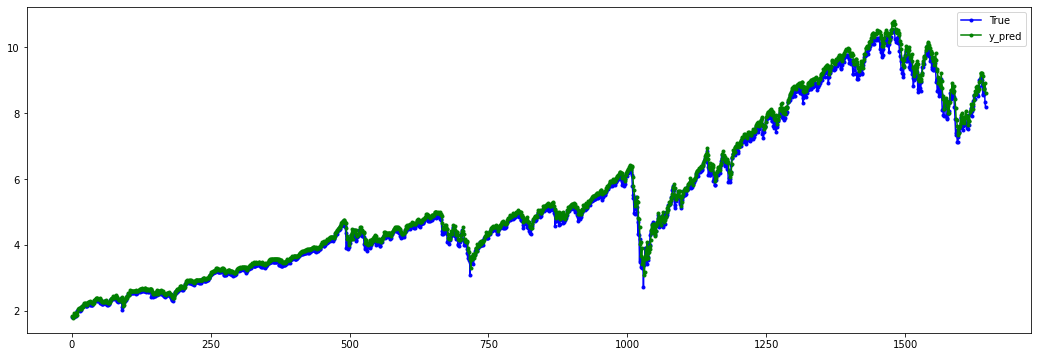

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(
    range(1, len(X_test) + 1),
    test[time_step:, :],
    color="b",
    marker=".",
    linestyle="-",
    label="True",
)
plt.plot(
    range(1, len(X_test) + 1),
    y_pred,
    color="g",
    marker=".",
    linestyle="-",
    label="y_pred",
)
plt.legend();

La anterior figura muestra los resultados con los datos escalados.

# **Predicción del modelo con valores sin escalar:**

A continuación, se realiza la predicción del modelo con valores sin escalar:

Para escalar los datos se usó sc.transform(), ahora, nuevamente para escalarlos a la representación original se usa sc.inverse_transform().

In [ ]:
test = sc.inverse_transform(test)
X_test, y_test = split_sequence(test, time_step)

In [ ]:
X_test[0:1]

array([[[1855.  ],
        [1861.  ],
        [1899.25],
        [1870.25],
        [1896.  ],
        [1875.  ],
        [1880.75],
        [1930.  ],
        [1931.25],
        [1897.5 ],
        [1908.5 ],
        [1907.75],
        [1875.25],
        [1852.  ],
        [1848.25],
        [1846.75],
        [1824.5 ],
        [1858.25],
        [1888.75],
        [1922.75]]])

In [ ]:
X_test.shape

(1645, 20, 1)

In [ ]:
y_pred = model.predict(X_test)
y_pred[0:5]

array([[1960.2189],
       [1937.4294],
       [1956.1709],
       [1982.9901],
       [1962.9097]], dtype=float32)

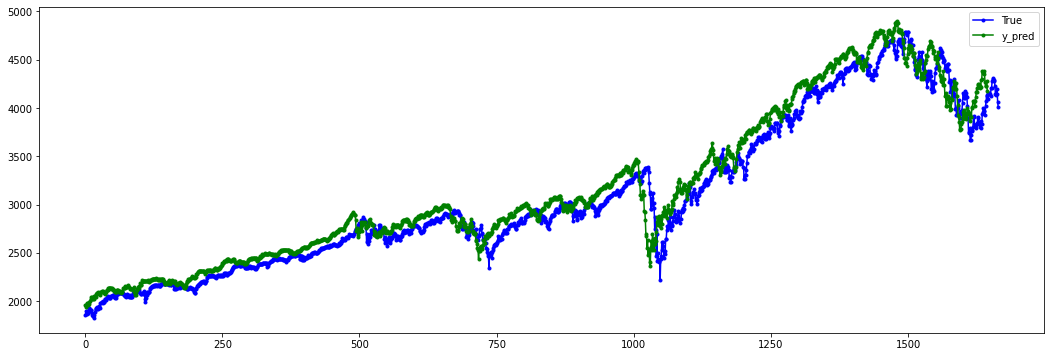

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(
    test, color="b", marker=".", linestyle="-", label="True",
)
plt.plot(
    y_pred, color="g", marker=".", linestyle="-", label="y_pred",
)
plt.legend();

# **Predicción fuera de la muestra:**

In [ ]:
df[-time_step:, 0]

array([4093.75, 4156.25, 4152.25, 4146.75, 4141.75, 4124.5 , 4210.  ,
       4209.75, 4281.  , 4298.25, 4307.75, 4276.75, 4286.5 , 4231.5 ,
       4141.25, 4130.5 , 4142.75, 4201.  , 4059.5 , 4011.5 ])

In [ ]:
predictions = []

time_prediction = 50  # cantidad de predicciones fuera de la muestra

first_sample = df[-time_step:, 0]  # última muestra dentro de la serie de tiempo
current_batch = first_sample[np.newaxis]  # Transformación en muestras y time step

for i in range(time_prediction):

    current_pred = model.predict(current_batch, verbose=0)[0]

    # Guardar la predicción
    predictions.append(current_pred)

    # Actualizar el lote para incluir ahora la predicción y soltar el primer valor (primer time step)
    current_batch = np.append(current_batch[:, 1:], [[current_pred]])[np.newaxis]

Figura con los 100 valores reales más recientes y las 50 predicciones:

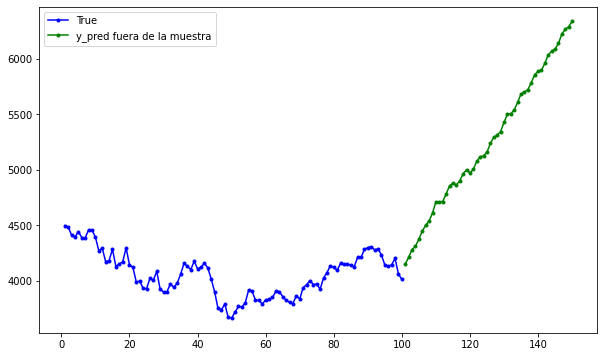

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(df[-100:, 0]) + 1),
    df[-100:, 0],
    color="b",
    marker=".",
    linestyle="-",
    label="True",
)
plt.plot(
    range(len(df[-100:, 0]) + 1, len(df[-100:, 0]) + len(predictions) + 1),
    predictions,
    color="g",
    marker=".",
    linestyle="-",
    label="y_pred fuera de la muestra",
)
plt.legend();

# **Predicción fuera de la muestra para 100 períodos:**

In [ ]:
predictions = []

time_prediction = 100  # cantidad de predicciones fuera de la muestra

first_sample = df[-time_step:, 0]  # última muestra dentro de la serie de tiempo
current_batch = first_sample[np.newaxis]  # Transformación en muestras y time step

for i in range(time_prediction):

    current_pred = model.predict(current_batch, verbose=0)[0]

    # Guardar la predicción
    predictions.append(current_pred)

    # Actualizar el lote para incluir ahora la predicción y soltar el primer valor (primer time step)
    current_batch = np.append(current_batch[:, 1:], [[current_pred]])[np.newaxis]

**Figura con los 100 valores reales más recientes y las 100 predicciones:**

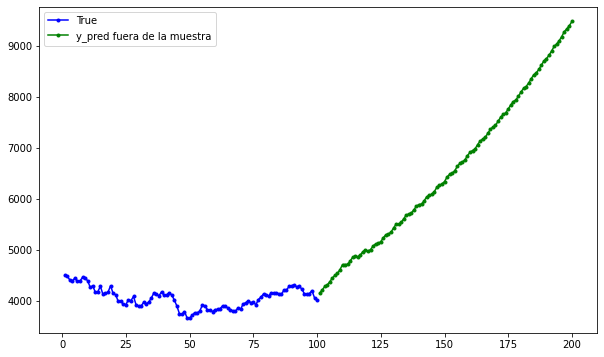

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(df[-100:, 0]) + 1),
    df[-100:, 0],
    color="b",
    marker=".",
    linestyle="-",
    label="True",
)
plt.plot(
    range(len(df[-100:, 0]) + 1, len(df[-100:, 0]) + len(predictions) + 1),
    predictions,
    color="g",
    marker=".",
    linestyle="-",
    label="y_pred fuera de la muestra",
)
plt.legend();

HASTA ACA EL CODIGO

# **Conjunto de train, validation y test:**

In [ ]:
time_valid = 0.10
time_test = 0.10

In [ ]:
train = df[: int(len(df) * (1 - (time_valid + time_test)))]
valid = df[
    int(len(df) * (1 - (time_valid + time_test))) : int(len(df) * (1 - time_test))
]
test = df[int(len(df) * (1 - time_test)) :]

In [ ]:
train.shape

(4437, 1)

In [ ]:
valid.shape

(555, 1)

In [ ]:
test.shape

(555, 1)

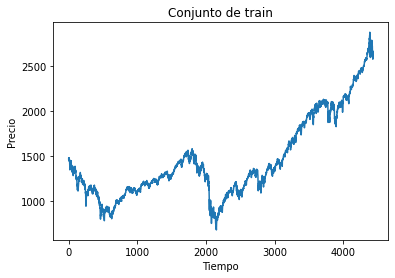

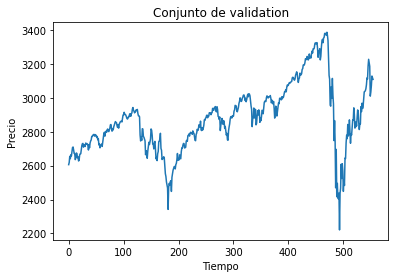

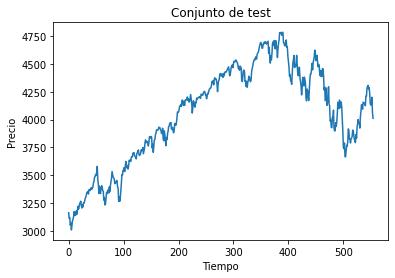

In [ ]:
plt.plot(train)
plt.xlabel("Tiempo")
plt.ylabel("Precio")
plt.title("Conjunto de train")
plt.show()

plt.plot(valid)
plt.xlabel("Tiempo")
plt.ylabel("Precio")
plt.title("Conjunto de validation")
plt.show()

plt.plot(test)
plt.xlabel("Tiempo")
plt.ylabel("Precio")
plt.title("Conjunto de test")
plt.show()

# **Estandarización de las variables:**

Con la información del conjunto de train se escalan los conjuntos de datos validation y test.

In [ ]:
sc = StandardScaler()
sc.fit(train)
train = sc.transform(train)
valid = sc.transform(valid)
test = sc.transform(test)

In [ ]:
train[0:5]

array([[0.0350991 ],
       [0.05900121],
       [0.03944494],
       [0.03944494],
       [0.03727202]])

In [ ]:
valid[0:5]

array([[2.50842387],
       [2.53721504],
       [2.61544012],
       [2.58501926],
       [2.63499639]])

In [ ]:
test[0:5]

array([[3.71550199],
       [3.60574784],
       [3.62258796],
       [3.47157011],
       [3.51883109]])

Función para conformar el dataset para datos secuenciales:

Se usarán 12 datos secuenciales para predicir el siguiente valor.

In [ ]:
time_step = 12

X_train, y_train = split_sequence(train, time_step)
X_valid, y_valid = split_sequence(valid, time_step)
X_test, y_test = split_sequence(test, time_step)

In [ ]:
X_train.shape

(4425, 12, 1)

In [ ]:
y_train.shape

(4425, 1)

In [ ]:
X_valid.shape

(543, 12, 1)

In [ ]:
X_test.shape

(543, 12, 1)

In [ ]:
y_test.shape

(543, 1)

**Arquitectura de la red:**

**Entrenamiento con el conjunto de train y evaluación con el conjunto de validation:**

In [ ]:
model = Sequential()
model.add(Dense(10, activation="relu", input_shape=(time_step,)))
model.add(Dense(1))
model.compile(optimizer="sgd", loss="mse")
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=500,
    batch_size=50,
    verbose=0,
)

# **Evaluación del desempeño en el conjunto de validation:**

In [ ]:
model.evaluate(X_valid, y_valid)

17/17 [==============================] - 0s 1ms/step - loss: 0.0119


0.011892127804458141

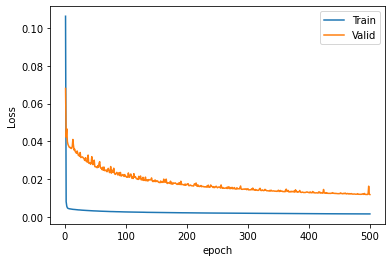

In [ ]:
plt.plot(range(1, len(history.epoch) + 1), history.history["loss"], label="Train")
plt.plot(range(1, len(history.epoch) + 1), history.history["val_loss"], label="Valid")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend();

Entrenamiento con los conjuntos de train y validation y evaluación con el conjunto de test:

Ahora, el conjunto de train nuevo tendrá el conjunto de train y el conjunto de valid.

In [ ]:
X_train_ = np.append(X_train, X_valid, axis=0)

In [ ]:
X_train_.shape

(4968, 12, 1)

In [ ]:
y_train_ = np.append(y_train, y_valid, axis=0)

In [ ]:
y_train_.shape

(4968, 1)

In [ ]:
model = Sequential()
model.add(Dense(10, activation="relu", input_shape=(time_step,)))
model.add(Dense(1))
model.compile(optimizer="sgd", loss="mse")
history = model.fit(
    X_train_,
    y_train_,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=50,
    verbose=0,
)

**Evaluación del desempeño en el conjunto de test:**

In [ ]:
model.evaluate(X_test, y_test)

17/17 [==============================] - 0s 2ms/step - loss: 0.0122


0.012243508361279964

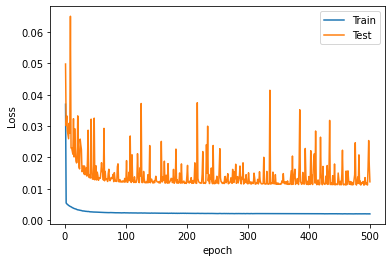

In [ ]:
plt.plot(range(1, len(history.epoch) + 1), history.history["loss"], label="Train")
plt.plot(range(1, len(history.epoch) + 1), history.history["val_loss"], label="Test")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend();

# **Predicción del modelo con valores sin escalar:**

In [ ]:
test = sc.inverse_transform(test)
X_test, y_test = split_sequence(test, time_step)

In [ ]:
y_pred = model.predict(X_test)
y_pred[0:5]

array([[3096.479 ],
       [3092.5723],
       [3125.1082],
       [3122.7112],
       [3144.2544]], dtype=float32)

In [ ]:
X_test.shape

(543, 12, 1)

In [ ]:
y_pred.shape

(543, 1)

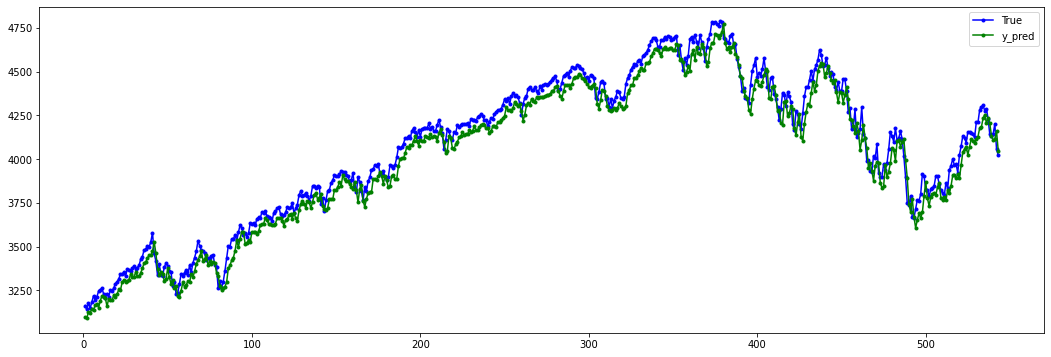

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(
    range(1, len(X_test) + 1),
    test[time_step:, :],
    color="b",
    marker=".",
    linestyle="-",
    label="True",
)
plt.plot(
    range(1, len(X_test) + 1),
    y_pred,
    color="g",
    marker=".",
    linestyle="-",
    label="y_pred",
)
plt.legend();

# **Predicción fuera de la muestra:**

Predicción fuera de la muestra para 20 períodos:

In [ ]:
predictions = []

time_prediction = 50  # cantidad de predicciones fuera de la muestra

first_sample = df[-time_step:, 0]         # última muestra dentro de la serie de tiempo
current_batch = first_sample[np.newaxis]  # Transformación en muestras y time step

for i in range(time_prediction):

    current_pred = model.predict(current_batch, verbose=0)[0]

    # Guardar la predicción
    predictions.append(current_pred)

    # Actualizar el lote para incluir ahora la predicción y soltar el primer valor (primer time step)
    current_batch = np.append(current_batch[:, 1:], [[current_pred]])[np.newaxis]

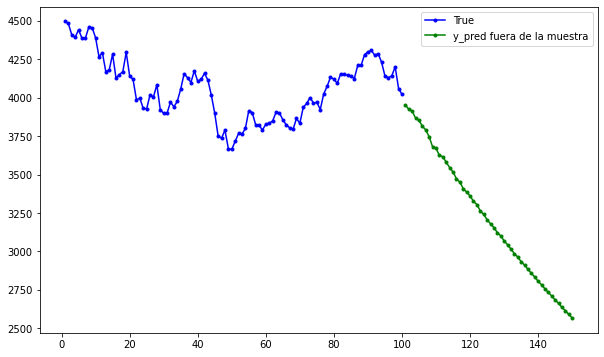

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(df[-100:, 0]) + 1),
    df[-100:, 0],
    color="b",
    marker=".",
    linestyle="-",
    label="True",
)
plt.plot(
    range(len(df[-100:, 0]) + 1, len(df[-100:, 0]) + len(predictions) + 1),
    predictions,
    color="g",
    marker=".",
    linestyle="-",
    label="y_pred fuera de la muestra",
)
plt.legend();